PROJECT 2

Joel Wheatley,
Yatharth Kumar,
Rajdeep Roy,
Arshdeep Singh

In [ ]:
# Connecting to Google Drive for accessing the dataset
import os
from google.colab import drive
drive.mount('/content/drive')
main_folder = "/content/drive/MyDrive/Project 2"
os.chdir(main_folder)


Mounted at /content/drive


In [ ]:
# packages for routine python code
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns

# packages for machine learning
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_curve, auc
from sklearn.model_selection import train_test_split

# common utils
import time
from tqdm.autonotebook import tqdm

# packages for deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image


/tmp/ipython-input-2026172863.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
# Load data
df = pd.read_csv("filtered_train_labels.csv")


In [ ]:
# Subset selection for testing

SUBSET_SIZE = 6000  # The size of the data

if SUBSET_SIZE is not None and SUBSET_SIZE < len(df):
    # Use train_test_split to get stratified sample
    df, _ = train_test_split(df, train_size=SUBSET_SIZE, random_state=42, stratify=df['label'])
    df = df.reset_index(drop=True)
    print(f"Using subset of {len(df)} images (stratified by label)")
    print(f"Class distribution: {df['label'].value_counts().to_dict()}")
else:
    print(f"Using all {len(df)} images")



Using subset of 6000 images (stratified by label)
Class distribution: {0: 3556, 1: 2444}


In [ ]:
def moveTo(obj, device):
    if isinstance(obj, list):
        return [moveTo(x, device) for x in obj]
    elif isinstance(obj, tuple):
        return tuple(moveTo(list(obj), device))
    elif isinstance(obj, set):
        return set(moveTo(list(obj), device))
    elif isinstance(obj, dict):
        to_ret = dict()
        for key, value in obj.items():
            to_ret[moveTo(key, device)] = moveTo(value, device)
        return to_ret
    elif isinstance(obj, torch.Tensor):
        return obj.to(device)
    else:
        return obj

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)


In [ ]:
#Control random seed for project
set_seed(42)

In [ ]:
#Set the GPU device for the project
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
!nvidia-smi

Sun Nov 16 18:38:08 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             43W /  400W |       5MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
# Dataset Class
image_folder = "Train"


#We have a large set of tif images in a folder. We will need to convert these into tensors. The below class will inherit the Pytorch Dataset class, as well as
#use the folder of images to initialize the tensors.
#The class also takes the label data frame as an input, so each image has a label.

class TiffDataset(Dataset):
    def __init__(self, dataframe, image_folder, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.image_folder = image_folder
        self.transform = transform
        self.dataframe["filename"] = self.dataframe["id"].astype(str) + ".tif"

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        filename = row['filename']
        label = row['label']
        image_path = os.path.join(self.image_folder, filename)
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:

# Training Function (FIXED validation loss bug)
def train_network(model, loss_func, train_loader, val_loader=None, score_funcs=None,
                  epochs=50, device="cpu", checkpoint_file=None,
                  lr_schedule=None, optimizer=None, disable_tqdm=False):

    """Train simple neural networks

    Keyword arguments:
    model -- the PyTorch model / "Module" to train
    loss_func -- the loss function that takes in batch in two arguments, the model outputs and the labels, and returns a score
    train_loader -- PyTorch DataLoader object that returns tuples of (input, label) pairs.
    val_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    score_funcs -- A dictionary of scoring functions to use to evalue the performance of the model
    epochs -- the number of training epochs to perform
    device -- the compute lodation to perform training

    """
    if score_funcs == None:
        score_funcs = {} #Empty set

    to_track = ["epoch", "total time", "train loss"]
    if val_loader is not None:
        to_track.append("val loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score)
        if val_loader is not None:
            to_track.append("val " + eval_score)

    total_train_time = 0 #How long have we spent in the training loop?
    results = {}
    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []

    if optimizer == None:
        #The AdamW optimizer is a good default optimizer
        optimizer = torch.optim.AdamW(model.parameters())
        del_opt = True
    else:
        del_opt = False

    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    print(f"{'Epoch':<8} {'Time':<10} {'Train Loss':<12} {'Val Loss':<12} {'Train Acc':<12} {'Val Acc':<12}")

    for epoch in tqdm(range(epochs), desc="Epoch", disable=disable_tqdm):
        model = model.train()
        running_loss = 0.0
        y_true = []
        y_pred = []

        start = time.time()
        for inputs, labels in tqdm(train_loader, desc="Train Batch", leave=False, disable=disable_tqdm):
            #Move the batch to the device we are using.
            inputs = moveTo(inputs, device)
            labels = moveTo(labels, device)

            if isinstance(labels, torch.Tensor):
                batch_size = labels.shape[0]
            elif isinstance(inputs, torch.Tensor):
                batch_size = inputs.shape[0]
            else:
                batch_size = len(inputs)

            # PyTorch stores gradients in a mutable data structure. So we need to set it to a clean state before we use it.
            # Otherwise, it will have old information from a previous iteration

            optimizer.zero_grad()
            y_hat = model(inputs) # this just computed f_Θ(x(i))

            # Compute loss
            loss = loss_func(y_hat, labels)
            loss.backward() # ∇_Θ just got computed by this one call!

            #Now we just need to update all the parameters!
            optimizer.step()# Θ_{k+1} = Θ_k − η * ∇_Θ ℓ(y_hat, y)

            #Now we are just grabbing some information we would like to have
            running_loss += loss.item() * batch_size

            if len(score_funcs) > 0 and isinstance(labels, torch.Tensor):
                #moving labels & predictions back to CPU for computing / storing predictions
                labels = labels.detach().cpu().numpy()
                y_hat = y_hat.detach().cpu().numpy()
                for i in range(batch_size):
                    y_true.append(labels[i])
                    y_pred.append(y_hat[i,:])
        #end training epoch
        end = time.time()
        total_train_time += (end - start)

        results["epoch"].append(epoch)
        results["total time"].append(total_train_time)
        results["train loss"].append(running_loss / len(train_loader.dataset))

        y_pred = np.asarray(y_pred)
        if len(y_pred.shape) == 2 and y_pred.shape[1] > 1: #We have a classification problem, convert to labels
            y_pred = np.argmax(y_pred, axis=1)

        for name, score_func in score_funcs.items():
            try:
                results["train " + name].append(score_func(y_true, y_pred))
            except:
                results["train " + name].append(float("NaN"))

        if val_loader is not None:
            model = model.eval() # Lets find out validation performance as we go!
            y_true = []
            y_pred = []
            val_running_loss = 0.0

            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    if isinstance(labels, torch.Tensor):
                        batch_size = labels.shape[0]
                    elif isinstance(inputs, torch.Tensor):
                        batch_size = inputs.shape[0]
                    else:
                        batch_size = len(inputs)

                    y_hat = model(inputs)
                    loss = loss_func(y_hat, labels)

                    #Now we are just grabbing some information we would like to have
                    val_running_loss += loss.item() * batch_size

                    if len(score_funcs) > 0 and isinstance(labels, torch.Tensor):
                        #moving labels & predictions back to CPU for computing / storing predictions
                        labels = labels.detach().cpu().numpy()
                        y_hat = y_hat.detach().cpu().numpy()
                        for i in range(batch_size):
                            y_true.append(labels[i])
                            y_pred.append(y_hat[i,:])


            results["val loss"].append(val_running_loss / len(val_loader.dataset))

            y_pred = np.asarray(y_pred)

            if len(y_pred.shape) == 2 and y_pred.shape[1] > 1: #We have a classification problem, convert to labels
                y_pred = np.argmax(y_pred, axis=1)

            for name, score_func in score_funcs.items():
                try:
                    results["val " + name].append(score_func(y_true, y_pred))
                except:
                    results["val " + name].append(float("NaN"))

        #In PyTorch, the convention is to update the learning rate after every epoch
        if lr_schedule is not None:
            if isinstance(lr_schedule, torch.optim.lr_scheduler.ReduceLROnPlateau):
                lr_schedule.step(val_running_loss)
            else:
                lr_schedule.step()

        if checkpoint_file is not None:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'results': results
            }, checkpoint_file)

        last_row = (pd.DataFrame.from_dict(results)).iloc[-1]
        print(f"{int(last_row['epoch']):<8} {last_row['total time']:<10.2f} {last_row['train loss']:<12.4f} {last_row['val loss']:<12.4f} {last_row['train Accuracy']:<12.4f} {last_row['val Accuracy']:<12.4f}")

    if del_opt:
        del optimizer

    return pd.DataFrame.from_dict(results)


In [ ]:
# Function to capture predictions for ROC curve
def get_predictions(model, data_loader, device):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)[:, 1]

            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.numpy())

    return np.array(all_labels), np.array(all_probs)

# Function to plot the ROC curves
def plot_roc_curve(results_dict, test_loader, device):
    plt.figure(figsize=(10, 8))

    for name, (model, _) in results_dict.items():
        y_true, y_probs = get_predictions(model, test_loader, device)
        fpr, tpr, _ = roc_curve(y_true, y_probs)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})', linewidth=2)

    plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curves - Cancer Detection Models', fontsize=14)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.show()


In [ ]:
# LeNet Model Definitions
LeNet = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2),
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5),
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16*22*22, 120),
    nn.ReLU(),
    nn.Linear(120, 84),
    nn.ReLU(),
    nn.Linear(84, 2)
)

In [ ]:
def print_dim(model, input_size):
  X = torch.rand(size=(1, 1, input_size, input_size), dtype=torch.float32)
  for layer in model:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)

In [ ]:
print_dim(LeNet, 96)

Conv2d output shape: 	 torch.Size([1, 6, 96, 96])
ReLU output shape: 	 torch.Size([1, 6, 96, 96])
AvgPool2d output shape: 	 torch.Size([1, 6, 48, 48])
Conv2d output shape: 	 torch.Size([1, 16, 44, 44])
ReLU output shape: 	 torch.Size([1, 16, 44, 44])
AvgPool2d output shape: 	 torch.Size([1, 16, 22, 22])
Flatten output shape: 	 torch.Size([1, 7744])
Linear output shape: 	 torch.Size([1, 120])
ReLU output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
ReLU output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 2])


In [ ]:
# AlexNet Model Definitions
AlexNet = nn.Sequential(
    nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
    nn.Linear(6400, 4096), nn.ReLU(), nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(p=0.5),
    nn.Linear(4096, 2)
)

In [ ]:
# Data Augmentation Strategies
# Basic augmentation with rotation and crop
train_transform_v1 = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomRotation(15),
    transforms.Resize((96, 96)),
    transforms.RandomResizedCrop(96, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Enhanced augmentation with flips and color jitter
train_transform_v2 = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.Resize((96, 96)),
    transforms.RandomResizedCrop(96, scale=(0.75, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# For AlexNet (3 channels)
train_transform_alexnet_v1 = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomRotation(15),
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_transform_alexnet_v2 = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224, scale=(0.75, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Test transforms (no augmentation)
test_transform_lenet = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transform_alexnet = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Split data
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
print(f"Training samples: {len(train_df)}, Test samples: {len(test_df)}")

# Dictionary to store all results
all_results = {}


Training samples: 4800, Test samples: 1200


In [ ]:
train_df

,id,label
3014,0a3e311028fac8297dc11605b499e7bad4ed72f3,0
1273,fe0b2534d389fd7eaa88d123f383c98bed04ad98,0
5856,0f466bb1058b6bc5551e6e9643ee9dab9c2d46b3,1
3191,0f2f3752ebf5e3d4e1cc057abe5ee57df3629443,0
2958,fecab5052520fd69f4b3129b1f2f26ae73af7717,0
...,...,...
1384,fcaddb1c9c660daf06114f743093e5c9952d32cf,0
491,1a84fd43a3e4a266c6b3302188982f4857f6a2b2,0
3460,f82364eebf9fa78a8b28d116a398356cd6c436fe,0
2950,1b05f55218ea43f3e35ce13155df9f303710dde4,1


In [ ]:
# LeNet + AdamW + StepLR + Augmentation V1

# Optional Training Options
BATCH_SIZE = 64      # Can be increased for faster training
NUM_EPOCHS = 15      # can be reduced  for quick testing

train_dataset = TiffDataset(train_df, image_folder, transform=train_transform_v1)
test_dataset = TiffDataset(test_df, image_folder, transform=test_transform_lenet)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [ ]:
images, labels = next(iter(train_loader))
x, y = next(iter(train_loader))

In [ ]:
x.shape

torch.Size([64, 1, 96, 96])

In [ ]:
y

tensor([0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0,
        1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1])

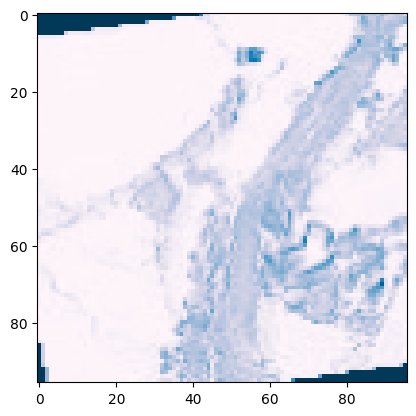

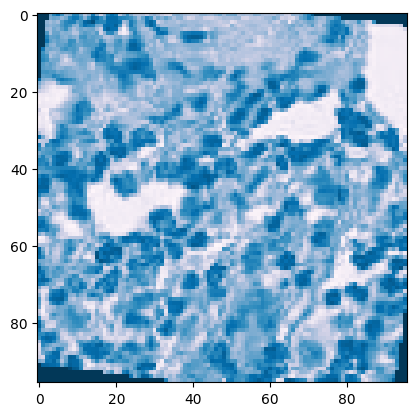

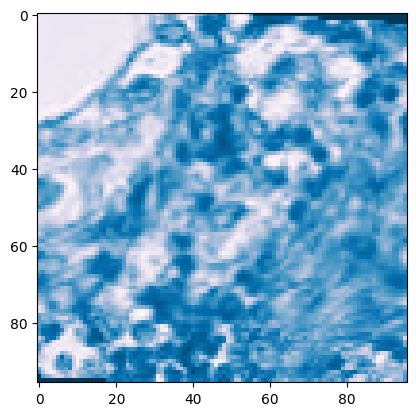

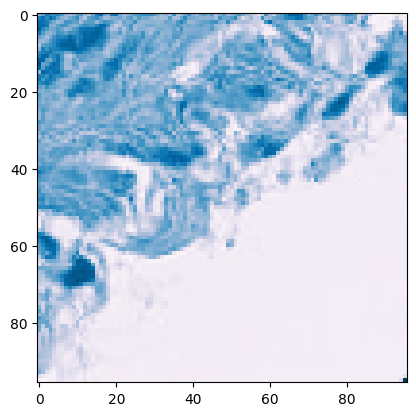

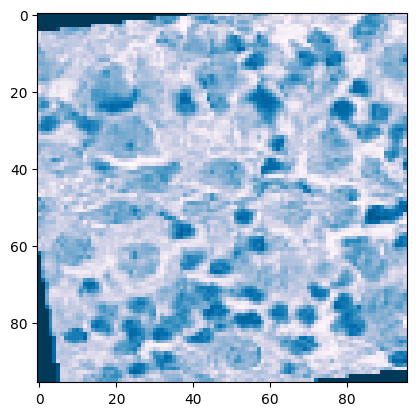

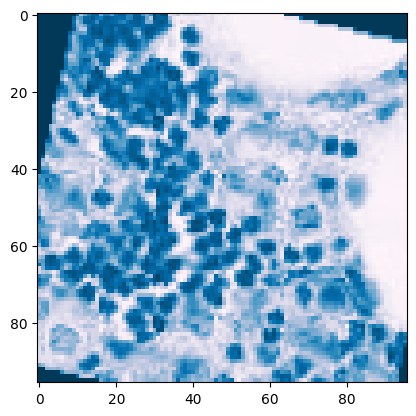

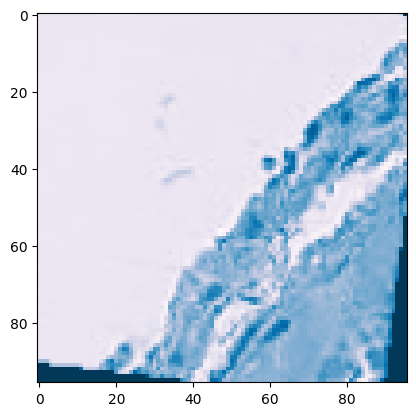

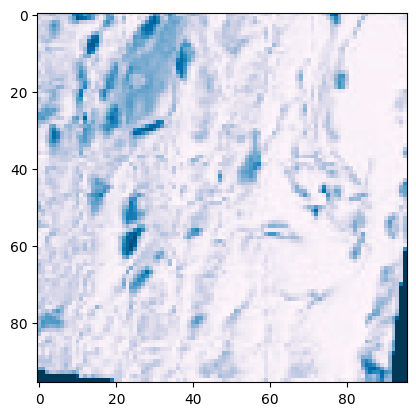

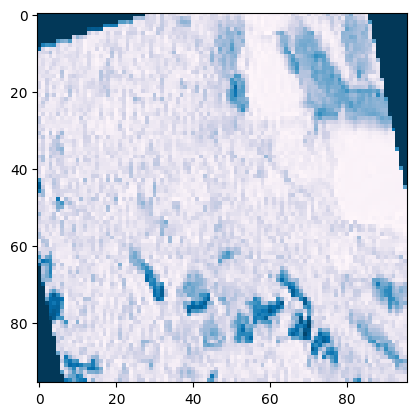

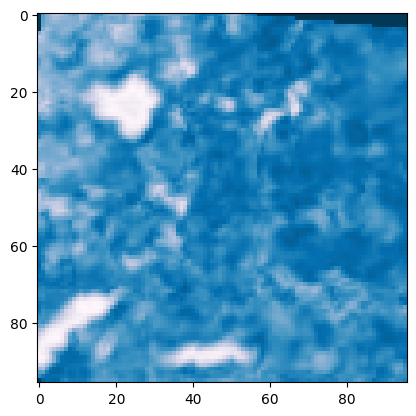

In [ ]:
for i in range(0, 10):
    imshow(x[i,0, :], cmap="PuBu_r")
    plt.show()

In [ ]:
print("MODEL 1 - LeNet + AdamW + StepLR + Basic Augmentation")

lenet_model_1 = LeNet
optimizer_adamw = torch.optim.AdamW(lenet_model_1.parameters(), lr=0.001)
scheduler_step = torch.optim.lr_scheduler.StepLR(optimizer_adamw, step_size=5, gamma=0.5)
loss_func = nn.CrossEntropyLoss()

results_1 = train_network(lenet_model_1, loss_func, train_loader, val_loader=test_loader,
                          optimizer=optimizer_adamw, lr_schedule=scheduler_step,
                          score_funcs={'Accuracy': accuracy_score}, device=device, epochs=NUM_EPOCHS)

all_results['LeNet_AdamW_StepLR_Aug1'] = (lenet_model_1, results_1)


MODEL 1 - LeNet + AdamW + StepLR + Basic Augmentation
Epoch    Time       Train Loss   Val Loss     Train Acc    Val Acc     


Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/75 [00:00<?, ?it/s]

0        3842.27    0.5623       0.5678       0.6960       0.7400      


Train Batch:   0%|          | 0/75 [00:00<?, ?it/s]

1        3856.65    0.4835       0.7315       0.7794       0.6592      


Train Batch:   0%|          | 0/75 [00:00<?, ?it/s]

2        3870.71    0.4845       0.5195       0.7740       0.7592      


Train Batch:   0%|          | 0/75 [00:00<?, ?it/s]

3        3885.16    0.4658       0.4759       0.7856       0.7825      


Train Batch:   0%|          | 0/75 [00:00<?, ?it/s]

4        3899.34    0.4634       0.5706       0.7860       0.7342      


Train Batch:   0%|          | 0/75 [00:00<?, ?it/s]

5        3913.72    0.4543       0.5260       0.7981       0.7583      


Train Batch:   0%|          | 0/75 [00:00<?, ?it/s]

6        3927.92    0.4511       0.5604       0.8008       0.7442      


Train Batch:   0%|          | 0/75 [00:00<?, ?it/s]

7        3942.37    0.4484       0.5625       0.8004       0.7358      


Train Batch:   0%|          | 0/75 [00:00<?, ?it/s]

8        3956.79    0.4529       0.5936       0.7948       0.7258      


Train Batch:   0%|          | 0/75 [00:00<?, ?it/s]

9        3971.12    0.4469       0.4804       0.7946       0.7825      


Train Batch:   0%|          | 0/75 [00:00<?, ?it/s]

10       3985.57    0.4400       0.5247       0.8013       0.7575      


Train Batch:   0%|          | 0/75 [00:00<?, ?it/s]

11       3999.77    0.4360       0.4860       0.8042       0.7775      


Train Batch:   0%|          | 0/75 [00:00<?, ?it/s]

12       4014.18    0.4395       0.5325       0.8042       0.7617      


Train Batch:   0%|          | 0/75 [00:00<?, ?it/s]

13       4028.85    0.4358       0.4946       0.8042       0.7767      


Train Batch:   0%|          | 0/75 [00:00<?, ?it/s]

14       4043.29    0.4341       0.4681       0.8090       0.7842      


In [ ]:
# LeNet + SGD + ReduceLROnPlateau + Augmentation V2

print("MODEL 2: LeNet + SGD + ReduceLROnPlateau + Enhanced Augmentation")

train_dataset = TiffDataset(train_df, image_folder, transform=train_transform_v2)
test_dataset = TiffDataset(test_df, image_folder, transform=test_transform_lenet)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

lenet_model_2 = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16*22*22, 120), nn.ReLU(),
    nn.Linear(120, 84), nn.ReLU(),
    nn.Linear(84, 2)
)

optimizer_sgd = torch.optim.SGD(lenet_model_2.parameters(), lr=0.01, momentum=0.9)
scheduler_plateau = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_sgd, mode='min', patience=3, factor=0.5
)
loss_func = nn.CrossEntropyLoss()

results_2 = train_network(lenet_model_2, loss_func, train_loader, val_loader=test_loader,
                          optimizer=optimizer_sgd, lr_schedule=scheduler_plateau,
                          score_funcs={'Accuracy': accuracy_score}, device=device, epochs=NUM_EPOCHS)

all_results['LeNet_SGD_Plateau_Aug2'] = (lenet_model_2, results_2)


MODEL 2: LeNet + SGD + ReduceLROnPlateau + Enhanced Augmentation
Epoch    Time       Train Loss   Val Loss     Train Acc    Val Acc     


Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/75 [00:00<?, ?it/s]

0        15.83      0.6670       0.6309       0.5808       0.5925      


Train Batch:   0%|          | 0/75 [00:00<?, ?it/s]

1        31.97      0.6162       0.5570       0.6665       0.7150      


Train Batch:   0%|          | 0/75 [00:00<?, ?it/s]

2        47.61      0.5837       0.5171       0.6998       0.7825      


Train Batch:   0%|          | 0/75 [00:00<?, ?it/s]

3        63.39      0.5815       0.5331       0.6977       0.7225      


Train Batch:   0%|          | 0/75 [00:00<?, ?it/s]

4        79.24      0.5468       0.5089       0.7217       0.7633      


Train Batch:   0%|          | 0/75 [00:00<?, ?it/s]

5        95.22      0.5494       0.5254       0.7323       0.7383      


Train Batch:   0%|          | 0/75 [00:00<?, ?it/s]

6        111.16     0.5446       0.5016       0.7238       0.7550      


Train Batch:   0%|          | 0/75 [00:00<?, ?it/s]

7        127.15     0.5481       0.5601       0.7254       0.6817      


Train Batch:   0%|          | 0/75 [00:00<?, ?it/s]

8        143.52     0.5333       0.5103       0.7358       0.7800      


Train Batch:   0%|          | 0/75 [00:00<?, ?it/s]

9        159.33     0.5498       0.5415       0.7288       0.7267      


Train Batch:   0%|          | 0/75 [00:00<?, ?it/s]

10       175.72     0.5383       0.5403       0.7348       0.7483      


Train Batch:   0%|          | 0/75 [00:00<?, ?it/s]

11       191.66     0.5275       0.5047       0.7394       0.7592      


Train Batch:   0%|          | 0/75 [00:00<?, ?it/s]

12       207.69     0.5209       0.5579       0.7458       0.7283      


Train Batch:   0%|          | 0/75 [00:00<?, ?it/s]

13       223.50     0.5252       0.5162       0.7396       0.7667      


Train Batch:   0%|          | 0/75 [00:00<?, ?it/s]

14       239.56     0.5210       0.5395       0.7467       0.7225      


In [ ]:
# AlexNet + Adam + StepLR + Augmentation V1

print("MODEL 3: AlexNet + Adam + StepLR + Basic Augmentation")

# Optional Training Options
BATCH_SIZE_ALEXNET = 32  # Smaller batch size for AlexNet (larger model)
NUM_EPOCHS_ALEXNET = 12  # Can be Reduced for quick testing

train_dataset = TiffDataset(train_df, image_folder, transform=train_transform_alexnet_v1)
test_dataset = TiffDataset(test_df, image_folder, transform=test_transform_alexnet)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_ALEXNET, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE_ALEXNET, shuffle=False)

alexnet_model_1 = AlexNet
optimizer_adam = torch.optim.Adam(alexnet_model_1.parameters(), lr=0.0001)
scheduler_step_alex = torch.optim.lr_scheduler.StepLR(optimizer_adam, step_size=5, gamma=0.5)
loss_func = nn.CrossEntropyLoss()

results_3 = train_network(alexnet_model_1, loss_func, train_loader, val_loader=test_loader,
                          optimizer=optimizer_adam, lr_schedule=scheduler_step_alex,
                          score_funcs={'Accuracy': accuracy_score}, device=device, epochs=NUM_EPOCHS_ALEXNET)

all_results['AlexNet_Adam_StepLR_Aug1'] = (alexnet_model_1, results_3)


MODEL 3: AlexNet + Adam + StepLR + Basic Augmentation
Epoch    Time       Train Loss   Val Loss     Train Acc    Val Acc     


Epoch:   0%|          | 0/12 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/150 [00:00<?, ?it/s]

0        26.40      0.6078       0.5646       0.6677       0.7108      


Train Batch:   0%|          | 0/150 [00:00<?, ?it/s]

1        52.66      0.5102       0.4672       0.7633       0.7975      


Train Batch:   0%|          | 0/150 [00:00<?, ?it/s]

2        78.73      0.4972       0.4294       0.7681       0.8017      


Train Batch:   0%|          | 0/150 [00:00<?, ?it/s]

3        104.72     0.4864       0.5307       0.7756       0.7575      


Train Batch:   0%|          | 0/150 [00:00<?, ?it/s]

4        130.90     0.4650       0.4326       0.7848       0.8092      


Train Batch:   0%|          | 0/150 [00:00<?, ?it/s]

5        156.98     0.4475       0.4517       0.7979       0.8000      


Train Batch:   0%|          | 0/150 [00:00<?, ?it/s]

6        183.26     0.4418       0.5324       0.7992       0.7725      


Train Batch:   0%|          | 0/150 [00:00<?, ?it/s]

7        209.44     0.4481       0.4379       0.7935       0.7950      


Train Batch:   0%|          | 0/150 [00:00<?, ?it/s]

8        235.56     0.4388       0.4681       0.8040       0.7842      


Train Batch:   0%|          | 0/150 [00:00<?, ?it/s]

9        261.81     0.4357       0.4167       0.8008       0.8150      


Train Batch:   0%|          | 0/150 [00:00<?, ?it/s]

10       288.05     0.4203       0.4419       0.8127       0.8117      


Train Batch:   0%|          | 0/150 [00:00<?, ?it/s]

11       314.34     0.4132       0.4323       0.8106       0.8092      


In [ ]:
# AlexNet + AdamW + ReduceLROnPlateau + Augmentation V2

print("MODEL 4: AlexNet + AdamW + ReduceLROnPlateau + Enhanced Augmentation")


train_dataset = TiffDataset(train_df, image_folder, transform=train_transform_alexnet_v2)
test_dataset = TiffDataset(test_df, image_folder, transform=test_transform_alexnet)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_ALEXNET, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE_ALEXNET, shuffle=False)

alexnet_model_2 = nn.Sequential(
    nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
    nn.Linear(6400, 4096), nn.ReLU(), nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(p=0.5),
    nn.Linear(4096, 2)
)

optimizer_adamw_alex = torch.optim.AdamW(alexnet_model_2.parameters(), lr=0.0001, weight_decay=0.01)
scheduler_plateau_alex = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_adamw_alex, mode='min', patience=2, factor=0.5
)
loss_func = nn.CrossEntropyLoss()

results_4 = train_network(alexnet_model_2, loss_func, train_loader, val_loader=test_loader,
                          optimizer=optimizer_adamw_alex, lr_schedule=scheduler_plateau_alex,
                          score_funcs={'Accuracy': accuracy_score}, device=device, epochs=NUM_EPOCHS_ALEXNET)

all_results['AlexNet_AdamW_Plateau_Aug2'] = (alexnet_model_2, results_4)


MODEL 4: AlexNet + AdamW + ReduceLROnPlateau + Enhanced Augmentation
Epoch    Time       Train Loss   Val Loss     Train Acc    Val Acc     


Epoch:   0%|          | 0/12 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/150 [00:00<?, ?it/s]

0        32.93      0.6132       0.5384       0.6510       0.7192      


Train Batch:   0%|          | 0/150 [00:00<?, ?it/s]

1        65.98      0.5520       0.5216       0.7358       0.8000      


Train Batch:   0%|          | 0/150 [00:00<?, ?it/s]

2        98.88      0.5274       0.5249       0.7527       0.7483      


Train Batch:   0%|          | 0/150 [00:00<?, ?it/s]

3        131.86     0.5162       0.4740       0.7560       0.7750      


Train Batch:   0%|          | 0/150 [00:00<?, ?it/s]

4        164.88     0.5044       0.4401       0.7604       0.8042      


Train Batch:   0%|          | 0/150 [00:00<?, ?it/s]

5        197.78     0.4957       0.4434       0.7665       0.8075      


Train Batch:   0%|          | 0/150 [00:00<?, ?it/s]

6        230.96     0.4844       0.4305       0.7708       0.8050      


Train Batch:   0%|          | 0/150 [00:00<?, ?it/s]

7        264.05     0.4800       0.4582       0.7835       0.7850      


Train Batch:   0%|          | 0/150 [00:00<?, ?it/s]

8        297.28     0.4761       0.4456       0.7804       0.7900      


Train Batch:   0%|          | 0/150 [00:00<?, ?it/s]

9        330.51     0.4644       0.4333       0.7831       0.8083      


Train Batch:   0%|          | 0/150 [00:00<?, ?it/s]

10       363.73     0.4581       0.4567       0.7842       0.8000      


Train Batch:   0%|          | 0/150 [00:00<?, ?it/s]

11       396.87     0.4484       0.4661       0.7906       0.7825      


RESULTS SUMMARY


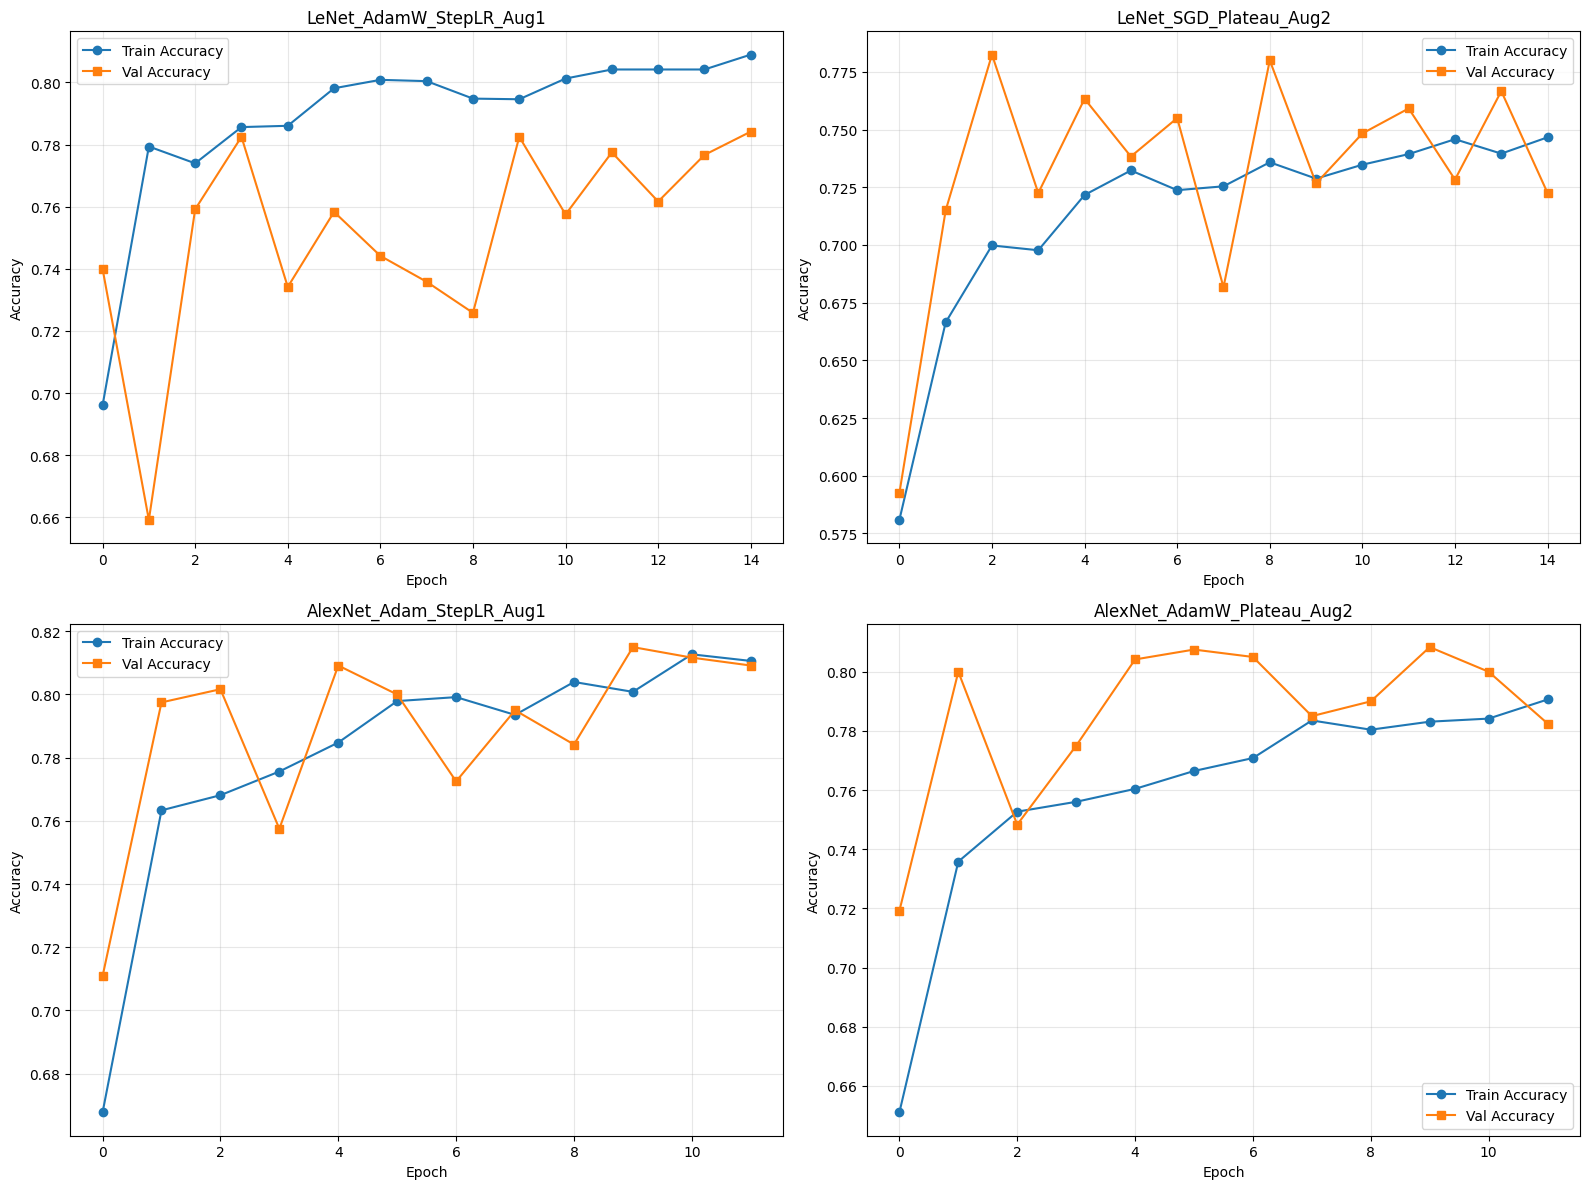


Generating ROC curves...


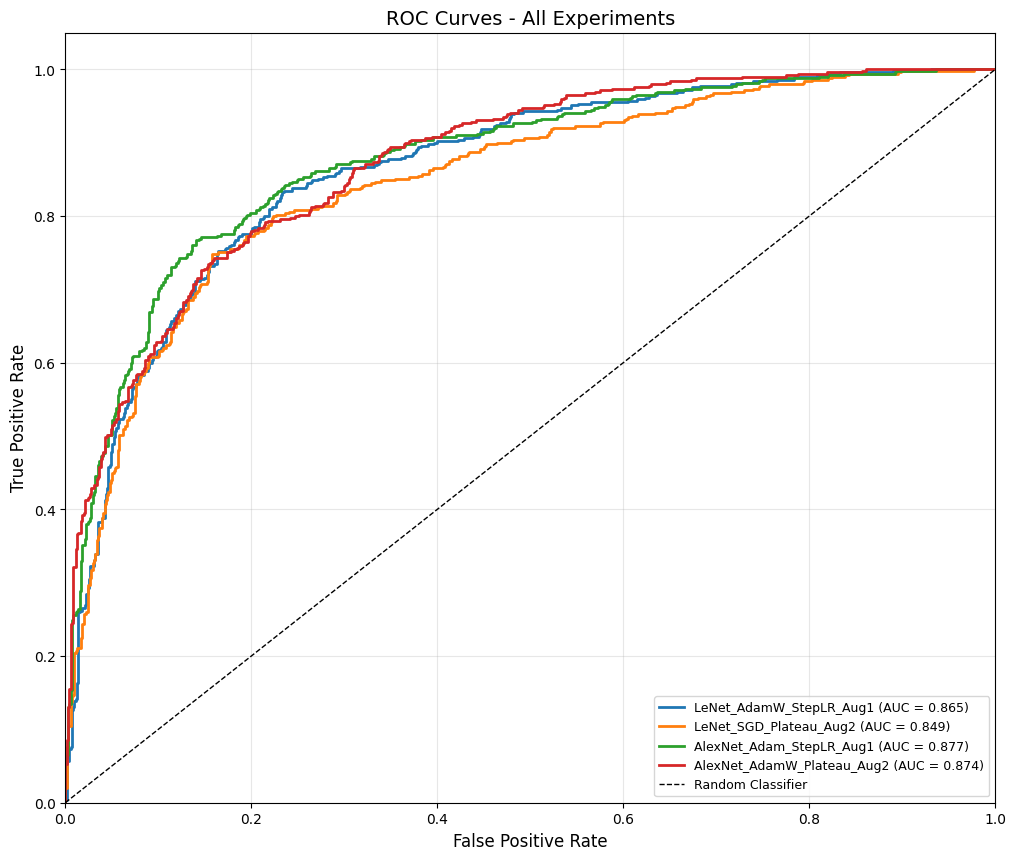


Final Validation Accuracies:
------------------------------------------------------------
LeNet_AdamW_StepLR_Aug1                  0.7842
LeNet_SGD_Plateau_Aug2                   0.7225
AlexNet_Adam_StepLR_Aug1                 0.8092
AlexNet_AdamW_Plateau_Aug2               0.7825


In [ ]:
# FINAL VISULIZATIONS


print("RESULTS SUMMARY")


# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for idx, (name, (model, results)) in enumerate(all_results.items()):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]

    ax.plot(results['epoch'], results['train Accuracy'], label='Train Accuracy', marker='o')
    ax.plot(results['epoch'], results['val Accuracy'], label='Val Accuracy', marker='s')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_title(f'{name}')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves_all_experiments.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot ROC curves for all models
print("\nGenerating ROC curves")
test_dataset_lenet = TiffDataset(test_df, image_folder, transform=test_transform_lenet)
test_loader_lenet = DataLoader(test_dataset_lenet, batch_size=64, shuffle=False)

test_dataset_alexnet = TiffDataset(test_df, image_folder, transform=test_transform_alexnet)
test_loader_alexnet = DataLoader(test_dataset_alexnet, batch_size=32, shuffle=False)

plt.figure(figsize=(12, 10))

# ROC for LeNet models
for name, (model, results) in list(all_results.items())[:2]:
    y_true, y_probs = get_predictions(model, test_loader_lenet, device)
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})', linewidth=2)

# ROC for AlexNet models
for name, (model, results) in list(all_results.items())[2:]:
    y_true, y_probs = get_predictions(model, test_loader_alexnet, device)
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - All Experiments', fontsize=14)
plt.legend(loc="lower right", fontsize=9)
plt.grid(alpha=0.3)
plt.savefig('roc_curves_all_experiments.png', dpi=300, bbox_inches='tight')
plt.show()

# Print final accuracies
print("\nFinal Validation Accuracies:")
print("-" * 60)
for name, (model, results) in all_results.items():
    final_acc = results['val Accuracy'].iloc[-1]
    print(f"{name:<40} {final_acc:.4f}")

